#**We employ the following models:**

1. CNN
2. LSTM
3. BiLSTM
4. GRU

#Hybrid
5. CNN-LSTM
6. CNN-BiLSTM
7. CNN-GRU


#**IMPORTS**

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector 
from tensorflow.keras.layers import TimeDistributed, Flatten

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.compat.v1 import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file = 'drive/MyDrive/Colab Notebooks/ja.csv'
#raw_data = pd.read_csv(file, parse_dates = ['date'], index_col = 'date')
raw_data = pd.read_csv(file)
df = raw_data.copy()
print(df.head())

         date  PM2dot5    PM10     NO    NO2    NOx    NH3    SO2    CO  \
0  01-02-2018   260.58  504.32  26.72  73.75  94.57  48.01  24.38  1.97   
1  02-02-2018   198.96  391.71  23.28  79.47  95.03  57.70  11.98  1.52   
2  03-02-2018   190.42  388.17  26.08  77.89  91.11  54.50  10.53  1.45   
3  04-02-2018   211.33  389.42  16.51  73.13  77.54  50.47  11.33  1.37   
4  05-02-2018   268.17  483.92  23.17  76.73  92.64  52.75  15.00  1.72   

   Ozone  Wind speed  
0    NaN        0.73  
1    NaN        0.77  
2    NaN        0.87  
3  13.32        0.95  
4  12.56        0.66  


In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.set_index('date', inplace=True)

In [ ]:
missing_values = df.isnull().sum().sum()
if missing_values > 0:
    print(f'There are {missing_values} missing values in the data.')

There are 57 missing values in the data.


In [ ]:
print(df.dtypes)

PM2dot5       float64
PM10          float64
NO            float64
NO2           float64
NOx           float64
NH3           float64
SO2           float64
CO            float64
Ozone         float64
Wind speed    float64
dtype: object


#**EDA & Preprocessing**

In [ ]:
df.describe()

,PM2dot5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Wind speed
count,1822.000000,1818.000000,1823.000000,1823.000000,1823.000000,1819.000000,1816.000000,1820.000000,1817.000000,1822.000000
mean,132.756647,260.776392,32.471980,59.337186,63.391179,60.413793,13.926999,1.548456,26.774810,0.545483
std,105.115303,149.575060,28.326179,37.264376,47.310181,29.113144,8.734893,0.678047,18.786644,0.359911
min,8.770000,15.480000,1.700000,8.630000,9.750000,1.300000,0.380000,0.000000,1.600000,0.130000
25%,52.057500,135.085000,11.065000,32.190000,28.140000,38.235000,8.100000,1.050000,10.340000,0.330000
50%,97.855000,244.570000,22.420000,50.800000,48.030000,52.550000,11.885000,1.440000,22.760000,0.450000
75%,187.382500,356.727500,45.960000,72.935000,85.435000,81.360000,18.175000,1.880000,39.850000,0.680000
max,658.260000,928.870000,166.490000,237.590000,336.640000,205.680000,85.380000,6.150000,91.420000,6.330000


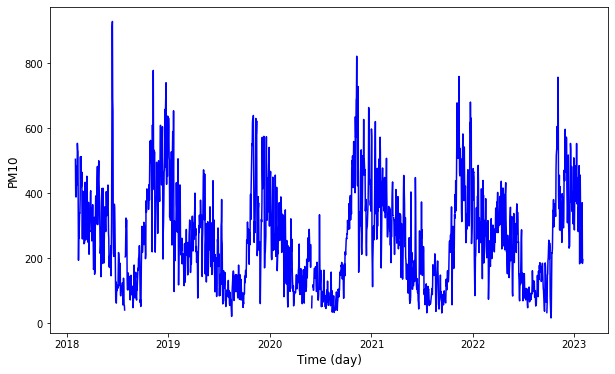

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='blue')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})

timeseries(df.index, df['PM10'], 'Time (day)', 'PM10')


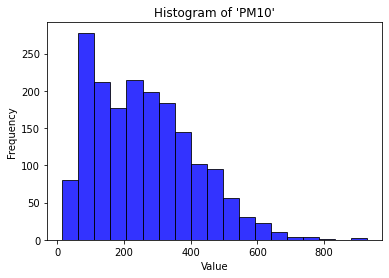

In [ ]:
def plot_histogram(x):
    plt.hist(x, bins = 19, alpha=0.8, color = 'blue', edgecolor = 'black')
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plot_histogram(df['PM10'])

In [ ]:
#RENAME
#df = df.rename(columns = {'Max Temp (C)':'Max_T', 'Min Temp (C)':'Min_T','Total Precip (mm)':'T_P','WC (m3/capita.day)':'UWC'})

# Missing values
df.isnull().sum()

PM2dot5        4
PM10           8
NO             3
NO2            3
NOx            3
NH3            7
SO2           10
CO             6
Ozone          9
Wind speed     4
dtype: int64

In [ ]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df['PM2dot5'])
replace_missing(df['PM10'])
replace_missing(df['NO'])
replace_missing(df['NO2'])
replace_missing(df['NOx'])
replace_missing(df['NH3'])
replace_missing(df['SO2'])
replace_missing(df['CO'])
replace_missing(df['Ozone'])
replace_missing(df['Wind speed'])

In [ ]:
nan_df = df.isna()
nan_count = nan_df.sum()
nan_count

PM2dot5       0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
SO2           0
CO            0
Ozone         3
Wind speed    0
dtype: int64

In [ ]:
df.fillna(26, inplace=True)

In [ ]:
assert not np.any(np.isnan(df))
df.to_csv("janew.csv", index=False)

In [ ]:
# Outlier detection
up_b = df['PM10'].mean() + 2*df['PM10'].std()
low_b = df['PM10'].mean() - 2*df['PM10'].std()

# Replace outlier by interpolation for base consumption
df.loc[df['PM10'] > up_b, 'PM10'] = np.nan
df.loc[df['PM10'] < low_b, 'PM10'] = np.nan
df['PM10'].interpolate(inplace=True)

## Train/validation split

Dimension of train data:  (1460, 10)
Dimension of test data:  (366, 10)


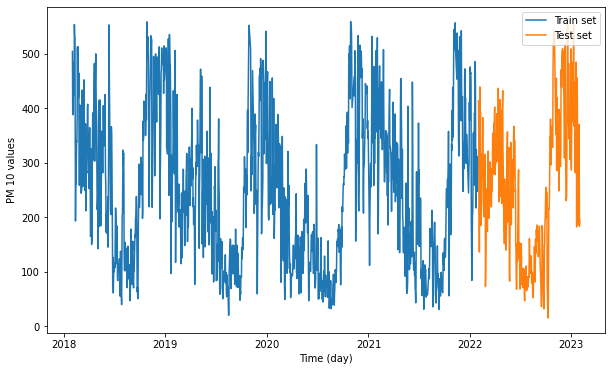

In [ ]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.PM10)
plt.plot(test_dataset.PM10)
plt.xlabel('Time (day)')
plt.ylabel('PM 10 values')
plt.legend(['Train set', 'Test set'], loc='upper right')
#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [ ]:
X_train = train_dataset.drop('PM10', axis = 1)
y_train = train_dataset.loc[:,['PM10']]

X_valid = test_dataset.drop('PM10', axis = 1)
y_valid = test_dataset.loc[:,['PM10']]

In [ ]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
valid_y_norm = output_scaler.transform(y_valid)
valid_x_norm = input_scaler.transform(X_valid)

In [ ]:
def create_dataset (X, Y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(Y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_valid, Y_valid = create_dataset(valid_x_norm, valid_y_norm, TIME_STEPS)
X_train, Y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_valid.shape)
print('Y_train.shape: ', Y_train.shape)
print('X_valid.shape: ', X_valid.shape) 
print('Y_valid.shape: ', Y_train.shape)

X_train.shape:  (336, 30, 9)
Y_train.shape:  (1430, 1)
X_valid.shape:  (336, 30, 9)
Y_valid.shape:  (1430, 1)


#**MODEL TRAINING**

#1. CNN

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
epochs = 40
batch = 256
lr = 0.00003
adam = optimizers.RMSprop(lr)

In [ ]:
X_train_series = X_train.reshape(1430,30,9)
X_valid_series = X_valid.reshape(336,30,9)
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1430, 30, 9)
Validation set shape (336, 30, 9)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_x_norm.shape[1], train_x_norm.shape[1])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
#model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
45/45 - 2s - loss: 0.1432 - val_loss: 0.0608 - 2s/epoch - 42ms/step
Epoch 2/40
45/45 - 0s - loss: 0.0514 - val_loss: 0.0475 - 394ms/epoch - 9ms/step
Epoch 3/40
45/45 - 1s - loss: 0.0401 - val_loss: 0.0434 - 613ms/epoch - 14ms/step
Epoch 4/40
45/45 - 0s - loss: 0.0365 - val_loss: 0.0374 - 496ms/epoch - 11ms/step
Epoch 5/40
45/45 - 1s - loss: 0.0345 - val_loss: 0.0344 - 591ms/epoch - 13ms/step
Epoch 6/40
45/45 - 1s - loss: 0.0330 - val_loss: 0.0327 - 519ms/epoch - 12ms/step
Epoch 7/40
45/45 - 1s - loss: 0.0319 - val_loss: 0.0322 - 750ms/epoch - 17ms/step
Epoch 8/40
45/45 - 1s - loss: 0.0311 - val_loss: 0.0312 - 576ms/epoch - 13ms/step
Epoch 9/40
45/45 - 0s - loss: 0.0304 - val_loss: 0.0306 - 455ms/epoch - 10ms/step
Epoch 10/40
45/45 - 1s - loss: 0.0297 - val_loss: 0.0301 - 517ms/epoch - 11ms/step
Epoch 11/40
45/45 - 0s - loss: 0.0292 - val_loss: 0.0298 - 337ms/epoch - 7ms/step
Epoch 12/40
45/45 - 0s - loss: 0.0288 - val_loss: 0.0292 - 324ms/epoch - 7ms/step
Epoch 13/40
45/45 -

#2. LSTM

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
#model_lstm.summary()

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
45/45 - 11s - loss: 0.1926 - val_loss: 0.1781 - 11s/epoch - 234ms/step
Epoch 2/40
45/45 - 1s - loss: 0.1690 - val_loss: 0.1547 - 1s/epoch - 31ms/step
Epoch 3/40
45/45 - 1s - loss: 0.1472 - val_loss: 0.1328 - 1s/epoch - 30ms/step
Epoch 4/40
45/45 - 2s - loss: 0.1271 - val_loss: 0.1125 - 2s/epoch - 47ms/step
Epoch 5/40
45/45 - 2s - loss: 0.1080 - val_loss: 0.0938 - 2s/epoch - 52ms/step
Epoch 6/40
45/45 - 1s - loss: 0.0908 - val_loss: 0.0772 - 1s/epoch - 32ms/step
Epoch 7/40
45/45 - 1s - loss: 0.0751 - val_loss: 0.0623 - 1s/epoch - 31ms/step
Epoch 8/40
45/45 - 1s - loss: 0.0616 - val_loss: 0.0509 - 1s/epoch - 31ms/step
Epoch 9/40
45/45 - 1s - loss: 0.0514 - val_loss: 0.0434 - 1s/epoch - 31ms/step
Epoch 10/40
45/45 - 1s - loss: 0.0442 - val_loss: 0.0400 - 1s/epoch - 30ms/step
Epoch 11/40
45/45 - 1s - loss: 0.0409 - val_loss: 0.0391 - 1s/epoch - 32ms/step
Epoch 12/40
45/45 - 1s - loss: 0.0394 - val_loss: 0.0384 - 1s/epoch - 31ms/step
Epoch 13/40
45/45 - 2s - loss: 0.0383 - val_lo

#3. BiLSTM

In [ ]:
# BiLSTM model
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional 

model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2]))))
model_bilstm.add(Dense(y_train.shape[1]))

model_bilstm.compile(loss='mse', optimizer='adam')

In [ ]:
bilstm_history = model_bilstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
45/45 - 4s - loss: 0.0747 - val_loss: 0.0421 - 4s/epoch - 89ms/step
Epoch 2/40
45/45 - 1s - loss: 0.0334 - val_loss: 0.0262 - 1s/epoch - 22ms/step
Epoch 3/40
45/45 - 1s - loss: 0.0267 - val_loss: 0.0304 - 1s/epoch - 23ms/step
Epoch 4/40
45/45 - 1s - loss: 0.0247 - val_loss: 0.0239 - 1s/epoch - 23ms/step
Epoch 5/40
45/45 - 1s - loss: 0.0224 - val_loss: 0.0203 - 993ms/epoch - 22ms/step
Epoch 6/40
45/45 - 1s - loss: 0.0213 - val_loss: 0.0201 - 1s/epoch - 23ms/step
Epoch 7/40
45/45 - 1s - loss: 0.0216 - val_loss: 0.0191 - 984ms/epoch - 22ms/step
Epoch 8/40
45/45 - 1s - loss: 0.0192 - val_loss: 0.0190 - 990ms/epoch - 22ms/step
Epoch 9/40
45/45 - 1s - loss: 0.0183 - val_loss: 0.0188 - 1s/epoch - 28ms/step
Epoch 10/40
45/45 - 2s - loss: 0.0181 - val_loss: 0.0185 - 2s/epoch - 41ms/step
Epoch 11/40
45/45 - 2s - loss: 0.0172 - val_loss: 0.0191 - 2s/epoch - 41ms/step
Epoch 12/40
45/45 - 1s - loss: 0.0165 - val_loss: 0.0227 - 1s/epoch - 23ms/step
Epoch 13/40
45/45 - 1s - loss: 0.0168 - 

#4. GRU

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_gru.add(Dense(y_train.shape[1]))

model_gru.compile(loss='mse', optimizer='adam')

In [ ]:
gru_history = model_gru.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
45/45 - 2s - loss: 0.1215 - val_loss: 0.0384 - 2s/epoch - 47ms/step
Epoch 2/40
45/45 - 1s - loss: 0.0321 - val_loss: 0.0264 - 665ms/epoch - 15ms/step
Epoch 3/40
45/45 - 1s - loss: 0.0254 - val_loss: 0.0233 - 967ms/epoch - 21ms/step
Epoch 4/40
45/45 - 1s - loss: 0.0231 - val_loss: 0.0218 - 1s/epoch - 24ms/step
Epoch 5/40
45/45 - 1s - loss: 0.0219 - val_loss: 0.0217 - 1s/epoch - 26ms/step
Epoch 6/40
45/45 - 1s - loss: 0.0209 - val_loss: 0.0191 - 1s/epoch - 25ms/step
Epoch 7/40
45/45 - 1s - loss: 0.0206 - val_loss: 0.0190 - 696ms/epoch - 15ms/step
Epoch 8/40
45/45 - 1s - loss: 0.0197 - val_loss: 0.0189 - 637ms/epoch - 14ms/step
Epoch 9/40
45/45 - 1s - loss: 0.0190 - val_loss: 0.0195 - 640ms/epoch - 14ms/step
Epoch 10/40
45/45 - 1s - loss: 0.0186 - val_loss: 0.0172 - 655ms/epoch - 15ms/step
Epoch 11/40
45/45 - 1s - loss: 0.0181 - val_loss: 0.0181 - 635ms/epoch - 14ms/step
Epoch 12/40
45/45 - 1s - loss: 0.0175 - val_loss: 0.0180 - 620ms/epoch - 14ms/step
Epoch 13/40
45/45 - 1s - 

#5. CNN-LSTM
* Input shape **[samples, subsequences, timesteps, features]**.


> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [ ]:
X_train_series_sub = X_train_series.reshape((1430,2,135,1))
X_valid_series_sub = X_valid_series.reshape((336,2,135,1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (1430, 2, 135, 1)
Validation set shape (336, 2, 135, 1)


In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D , MaxPooling1D , LSTM, TimeDistributed, Flatten, Bidirectional

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=2)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(32))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
45/45 - 7s - loss: 0.0924 - val_loss: 0.0399 - 7s/epoch - 145ms/step
Epoch 2/40
45/45 - 3s - loss: 0.0370 - val_loss: 0.0371 - 3s/epoch - 64ms/step
Epoch 3/40
45/45 - 3s - loss: 0.0343 - val_loss: 0.0421 - 3s/epoch - 62ms/step
Epoch 4/40
45/45 - 4s - loss: 0.0319 - val_loss: 0.0321 - 4s/epoch - 85ms/step
Epoch 5/40
45/45 - 4s - loss: 0.0302 - val_loss: 0.0287 - 4s/epoch - 86ms/step
Epoch 6/40
45/45 - 4s - loss: 0.0289 - val_loss: 0.0268 - 4s/epoch - 81ms/step
Epoch 7/40
45/45 - 6s - loss: 0.0279 - val_loss: 0.0290 - 6s/epoch - 143ms/step
Epoch 8/40
45/45 - 7s - loss: 0.0273 - val_loss: 0.0252 - 7s/epoch - 150ms/step
Epoch 9/40
45/45 - 6s - loss: 0.0260 - val_loss: 0.0245 - 6s/epoch - 133ms/step
Epoch 10/40
45/45 - 7s - loss: 0.0251 - val_loss: 0.0237 - 7s/epoch - 161ms/step
Epoch 11/40
45/45 - 3s - loss: 0.0242 - val_loss: 0.0236 - 3s/epoch - 71ms/step
Epoch 12/40
45/45 - 3s - loss: 0.0238 - val_loss: 0.0226 - 3s/epoch - 62ms/step
Epoch 13/40
45/45 - 3s - loss: 0.0232 - val_

#6. CNN-BiLSTM

In [ ]:
model_cnn_bilstm = Sequential()
model_cnn_bilstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_bilstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=2)))
model_cnn_bilstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_bilstm.add(TimeDistributed(Flatten()))
model_cnn_bilstm.add(Bidirectional(LSTM(50, activation='relu')))
model_cnn_bilstm.add(Dense(32))
model_cnn_bilstm.add(Dense(1))
model_cnn_bilstm.compile(loss='mse', optimizer=adam)

In [ ]:
cnn_bilstm_history = model_cnn_bilstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
45/45 - 10s - loss: 0.0707 - val_loss: 0.0403 - 10s/epoch - 212ms/step
Epoch 2/40
45/45 - 4s - loss: 0.0365 - val_loss: 0.0355 - 4s/epoch - 98ms/step
Epoch 3/40
45/45 - 4s - loss: 0.0334 - val_loss: 0.0396 - 4s/epoch - 98ms/step
Epoch 4/40
45/45 - 6s - loss: 0.0312 - val_loss: 0.0306 - 6s/epoch - 137ms/step
Epoch 5/40
45/45 - 4s - loss: 0.0297 - val_loss: 0.0282 - 4s/epoch - 98ms/step
Epoch 6/40
45/45 - 5s - loss: 0.0284 - val_loss: 0.0258 - 5s/epoch - 107ms/step
Epoch 7/40
45/45 - 6s - loss: 0.0274 - val_loss: 0.0274 - 6s/epoch - 128ms/step
Epoch 8/40
45/45 - 4s - loss: 0.0268 - val_loss: 0.0253 - 4s/epoch - 98ms/step
Epoch 9/40
45/45 - 5s - loss: 0.0255 - val_loss: 0.0239 - 5s/epoch - 117ms/step
Epoch 10/40
45/45 - 5s - loss: 0.0245 - val_loss: 0.0238 - 5s/epoch - 117ms/step
Epoch 11/40
45/45 - 4s - loss: 0.0237 - val_loss: 0.0232 - 4s/epoch - 97ms/step
Epoch 12/40
45/45 - 6s - loss: 0.0233 - val_loss: 0.0237 - 6s/epoch - 126ms/step
Epoch 13/40
45/45 - 5s - loss: 0.0229 - 

#7. CNN-GRU

In [ ]:
model_cnn_gru = Sequential()
model_cnn_gru.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_gru.add(TimeDistributed(Conv1D(filters=128, kernel_size=2)))
model_cnn_gru.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_gru.add(TimeDistributed(Flatten()))
model_cnn_gru.add(GRU(50, activation='relu'))
model_cnn_gru.add(Dense(32))
model_cnn_gru.add(Dense(1))
model_cnn_gru.compile(loss='mse', optimizer=adam)

In [ ]:
cnn_gru_history = model_cnn_gru.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
45/45 - 7s - loss: 0.0706 - val_loss: 0.0372 - 7s/epoch - 149ms/step
Epoch 2/40
45/45 - 3s - loss: 0.0337 - val_loss: 0.0301 - 3s/epoch - 58ms/step
Epoch 3/40
45/45 - 3s - loss: 0.0301 - val_loss: 0.0320 - 3s/epoch - 59ms/step
Epoch 4/40
45/45 - 3s - loss: 0.0278 - val_loss: 0.0262 - 3s/epoch - 60ms/step
Epoch 5/40
45/45 - 3s - loss: 0.0262 - val_loss: 0.0238 - 3s/epoch - 71ms/step
Epoch 6/40
45/45 - 4s - loss: 0.0249 - val_loss: 0.0211 - 4s/epoch - 86ms/step
Epoch 7/40
45/45 - 3s - loss: 0.0239 - val_loss: 0.0219 - 3s/epoch - 59ms/step
Epoch 8/40
45/45 - 3s - loss: 0.0233 - val_loss: 0.0212 - 3s/epoch - 59ms/step
Epoch 9/40
45/45 - 3s - loss: 0.0220 - val_loss: 0.0194 - 3s/epoch - 57ms/step
Epoch 10/40
45/45 - 4s - loss: 0.0212 - val_loss: 0.0190 - 4s/epoch - 83ms/step
Epoch 11/40
45/45 - 3s - loss: 0.0205 - val_loss: 0.0187 - 3s/epoch - 76ms/step
Epoch 12/40
45/45 - 3s - loss: 0.0201 - val_loss: 0.0212 - 3s/epoch - 57ms/step
Epoch 13/40
45/45 - 3s - loss: 0.0197 - val_loss

#**Comparing models**

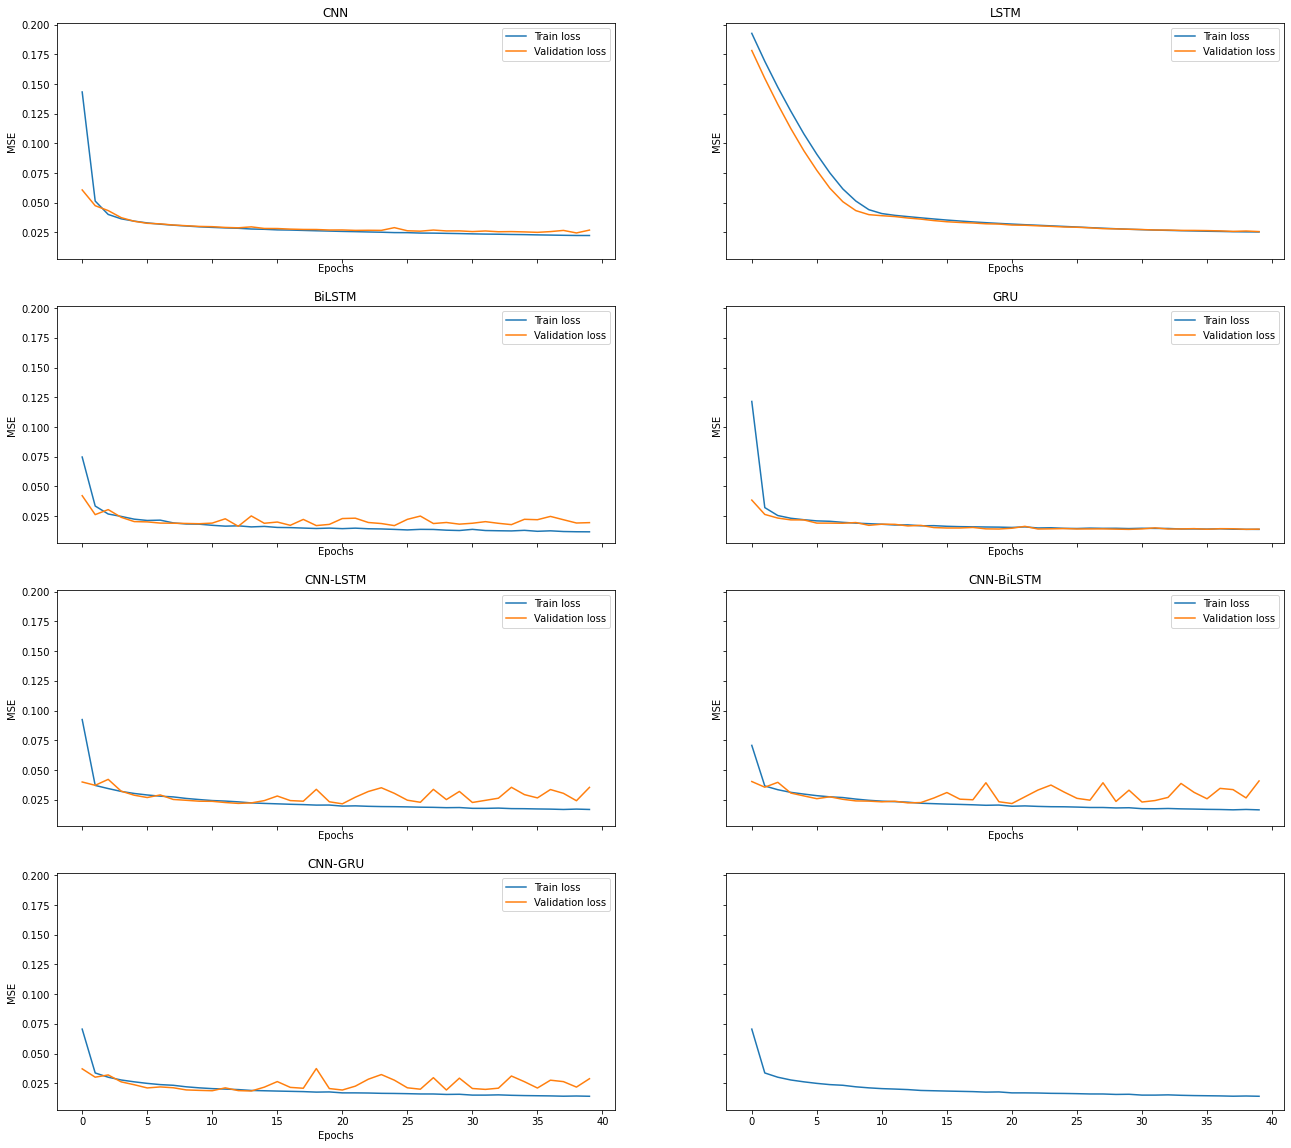

In [ ]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True,figsize=(22, 20))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]
ax5, ax6 = axes[2]
ax7, ax8 = axes[3]

ax1.plot(cnn_history.history['loss'], label='Train loss')
ax1.plot(cnn_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('CNN')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(lstm_history.history['loss'], label='Train loss')
ax2.plot(lstm_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('LSTM')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(bilstm_history.history['loss'], label='Train loss')
ax3.plot(bilstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('BiLSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(gru_history.history['loss'], label='Train loss')
ax4.plot(gru_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('GRU')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

ax5.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax5.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax5.legend(loc='best')
ax5.set_title('CNN-LSTM')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('MSE')

ax6.plot(cnn_bilstm_history.history['loss'], label='Train loss')
ax6.plot(cnn_bilstm_history.history['val_loss'], label='Validation loss')
ax6.legend(loc='best')
ax6.set_title('CNN-BiLSTM')
ax6.set_xlabel('Epochs')
ax6.set_ylabel('MSE')

ax7.plot(cnn_gru_history.history['loss'], label='Train loss')
ax7.plot(cnn_gru_history.history['val_loss'], label='Validation loss')
ax7.legend(loc='best')
ax7.set_title('CNN-GRU')
ax7.set_xlabel('Epochs')
ax7.set_ylabel('MSE')

ax8.plot(cnn_gru_history.history['loss'], label='Train loss')


plt.show()

#**MODEL EVALUATION**

1. Mean Absolute Error (MAE): This measures the average absolute difference between the actual and predicted values. A lower MAE indicates a better fit.

2. Mean Squared Error (MSE): This measures the average squared difference between the actual and predicted values. A lower MSE indicates a better fit.

3. Root Mean Squared Error (RMSE): This is the square root of the MSE, and provides an interpretable measure of the average error in the units of the response variable.

4. Mean Absolute Percentage Error (MAPE): This metric measures the average absolute percentage difference between the predicted values and the actual values.

5. Symmetric Mean Absolute Percentage Error (SMAPE): This metric is similar to MAPE but it is symmetrical, which means that it treats over- and under-predictions equally.

6. Correlation Coefficient: This metric measures the strength and direction of the linear relationship between two variables. A value closer to 1 indicates a strong positive correlation, and a value closer to -1 indicates a strong negative correlation.

7. R-squared: This measures the proportion of the variance in the response variable that is explained by the model. A higher R-Squared value indicates a better fit. A good value of the Coefficient of Determination (R-Squared) depends on the specific problem and goals of the analysis. In general, a value closer to 1 indicates a better fit of the model to the data, as it indicates that a larger proportion of the variance in the response variable is explained by the model. However, a value of 1 may indicate overfitting, where the model is too closely fit to the training data and may not generalize well to new data.A value closer to 0 indicates that the model does not fit the data well and may not be useful in making predictions. It is generally accepted that an R-Squared value greater than 0.7 is a good fit, while values greater than 0.9 indicate an excellent fit. However, these thresholds can vary based on the specific problem and the data at hand.

8. Mean Directional Accuracy (MDA): This metric measures the average deviation of the predicted values from the actual values, taking into account both the magnitude and direction of the errors.

## CNN on train and validation

In [ ]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train')
print('MAE:', mean_absolute_error(Y_train, cnn_train_pred))
print('MSE:', mean_squared_error(Y_train, cnn_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_train, cnn_train_pred))
print('R-squared', r2_score(Y_train, cnn_train_pred))

print('Validation')
print('MAE:', mean_absolute_error(Y_valid, cnn_valid_pred))
print('MSE:', mean_squared_error(Y_valid, cnn_valid_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_valid, cnn_valid_pred))
print('R-squared', r2_score(Y_valid, cnn_valid_pred))

11/11 [==============================] - 0s 3ms/step
Train
MAE: 0.11641549481195355
MSE: 0.022416418850576363
RMSE: 0.14972113695325842
MAPE: 321667614803.49054
R-squared 0.6481270732452082
Validation
MAE: 0.12652549380449796
MSE: 0.026963492669061045
RMSE: 0.1642056414044933
MAPE: 0.5168381848413391
R-squared 0.5577517664059781


## LSTM on train and validation

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
print('Train')
print('MAE:', mean_absolute_error(Y_train, lstm_train_pred))
print('MSE:', mean_squared_error(Y_train, lstm_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_train, lstm_train_pred))
print('R-squared', r2_score(Y_train, lstm_train_pred))

print('Validation')
print('MAE:', mean_absolute_error(Y_valid, lstm_valid_pred))
print('MSE:', mean_squared_error(Y_valid, lstm_valid_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_valid, lstm_valid_pred))
print('R-squared', r2_score(Y_valid, lstm_valid_pred))

11/11 [==============================] - 0s 19ms/step
Train
MAE: 0.1253410042828347
MSE: 0.025255639100624158
RMSE: 0.15892022873323633
MAPE: 665275510641.2927
R-squared 0.6035595289935938
Validation
MAE: 0.13017822848071384
MSE: 0.025708136118202943
RMSE: 0.1603375692662295
MAPE: 0.6546390919822784
R-squared 0.5783417998991062


##BiLSTM on train and validation

In [ ]:
bilstm_train_pred = model_bilstm.predict(X_train_series)
bilstm_valid_pred = model_bilstm.predict(X_valid_series)
print('Train')
print('MAE:', mean_absolute_error(Y_train, bilstm_train_pred))
print('MSE:', mean_squared_error(Y_train, bilstm_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_train, bilstm_train_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_train, bilstm_train_pred))
print('R-squared', r2_score(Y_train, bilstm_train_pred))

print('Validation')
print('MAE:', mean_absolute_error(Y_valid, bilstm_valid_pred))
print('MSE:', mean_squared_error(Y_valid, bilstm_valid_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_valid, bilstm_valid_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_valid, bilstm_valid_pred))
print('R-squared', r2_score(Y_valid, bilstm_valid_pred))

11/11 [==============================] - 0s 7ms/step
Train
MAE: 0.08218863439791026
MSE: 0.011715676112105108
RMSE: 0.10823897686187313
MAPE: 144988231379.52643
R-squared 0.8160977777067353
Validation
MAE: 0.11237964345945144
MSE: 0.019451650618674404
RMSE: 0.13946917443892182
MAPE: 0.44734340557908797
R-squared 0.6809590570413153


##GRU on train and validation

In [ ]:
gru_train_pred = model_gru.predict(X_train_series)
gru_valid_pred = model_gru.predict(X_valid_series)
print('Train')
print('MAE:', mean_absolute_error(Y_train, gru_train_pred))
print('MSE:', mean_squared_error(Y_train, gru_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_train, gru_train_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_train, gru_train_pred))
print('R-squared', r2_score(Y_train, gru_train_pred))

print('Validation')
print('MAE:', mean_absolute_error(Y_valid, gru_valid_pred))
print('MSE:', mean_squared_error(Y_valid, gru_valid_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_valid, gru_valid_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_valid, gru_valid_pred))
print('R-squared', r2_score(Y_valid, gru_valid_pred))

11/11 [==============================] - 0s 5ms/step
Train
MAE: 0.08726329493956414
MSE: 0.013537250192629455
RMSE: 0.11634968926743833
MAPE: 156018945859.2672
R-squared 0.7875043343343882
Validation
MAE: 0.09573430883310068
MSE: 0.013984631185472487
RMSE: 0.11825663273352784
MAPE: 0.4057258245695885
R-squared 0.7706276959314096


## CNN-LSTM on train and validation

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train')
print('MAE:', mean_absolute_error(Y_train, cnn_lstm_train_pred))
print('MSE:', mean_squared_error(Y_train, cnn_lstm_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_train, cnn_lstm_train_pred))
print('R-squared', r2_score(Y_train, cnn_lstm_train_pred))

print('Validation')
print('MAE:', mean_absolute_error(Y_valid, cnn_lstm_valid_pred))
print('MSE:', mean_squared_error(Y_valid, cnn_lstm_valid_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_valid, cnn_lstm_valid_pred))
print('R-squared', r2_score(Y_valid, cnn_lstm_valid_pred))

11/11 [==============================] - 0s 17ms/step
Train
MAE: 0.0999861942341017
MSE: 0.0170822134372987
RMSE: 0.13069894198997442
MAPE: 241782138218.69498
R-squared 0.7318586667344602
Validation
MAE: 0.14903102155044634
MSE: 0.03533599886125528
RMSE: 0.1879787191712277
MAPE: 0.4670605219328362
R-squared 0.42042808509737806


##CNN-BiLSTM on train and validation



In [ ]:
cnn_bilstm_train_pred = model_cnn_bilstm.predict(X_train_series_sub)
cnn_bilstm_valid_pred = model_cnn_bilstm.predict(X_valid_series_sub)
print('Train')
print('MAE:', mean_absolute_error(Y_train, cnn_bilstm_train_pred))
print('MSE:', mean_squared_error(Y_train, cnn_bilstm_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_train, cnn_bilstm_train_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_train, cnn_bilstm_train_pred))
print('R-squared', r2_score(Y_train, cnn_bilstm_train_pred))

print('Validation')
print('MAE:', mean_absolute_error(Y_valid, cnn_bilstm_valid_pred))
print('MSE:', mean_squared_error(Y_valid, cnn_bilstm_valid_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_valid, cnn_bilstm_valid_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_valid, cnn_bilstm_valid_pred))
print('R-squared', r2_score(Y_valid, cnn_bilstm_valid_pred))

11/11 [==============================] - 0s 24ms/step
Train
MAE: 0.10065858392933086
MSE: 0.017403581389943825
RMSE: 0.1319226341078127
MAPE: 175024704098.44492
R-squared 0.7268141195739075
Validation
MAE: 0.16288320501008482
MSE: 0.04075650352224888
RMSE: 0.20188240022906623
MAPE: 0.5008113569942875
R-squared 0.3315223694716264


##CNN-GRU on train and validation


In [ ]:
cnn_gru_train_pred = model_cnn_gru.predict(X_train_series_sub)
cnn_gru_valid_pred = model_cnn_gru.predict(X_valid_series_sub)
print('Train')
print('MAE:', mean_absolute_error(Y_train, cnn_gru_train_pred))
print('MSE:', mean_squared_error(Y_train, cnn_gru_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_train, cnn_gru_train_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_train, cnn_gru_train_pred))
print('R-squared', r2_score(Y_train, cnn_gru_train_pred))

print('Validation')
print('MAE:', mean_absolute_error(Y_valid, cnn_gru_valid_pred))
print('MSE:', mean_squared_error(Y_valid, cnn_gru_valid_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_valid, cnn_gru_valid_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_valid, cnn_gru_valid_pred))
print('R-squared', r2_score(Y_valid, cnn_gru_valid_pred))

11/11 [==============================] - 0s 25ms/step
Train
MAE: 0.09133232607039182
MSE: 0.0143823523182483
RMSE: 0.11992644544990191
MAPE: 111869432111.93456
R-squared 0.7742386757860534
Validation
MAE: 0.1334739745395994
MSE: 0.028840729458382584
RMSE: 0.169825585405682
MAPE: 0.4088751663568292
R-squared 0.5269618140691367


# **TRUE VS PREDICTION**

## CNN true future vs prediction

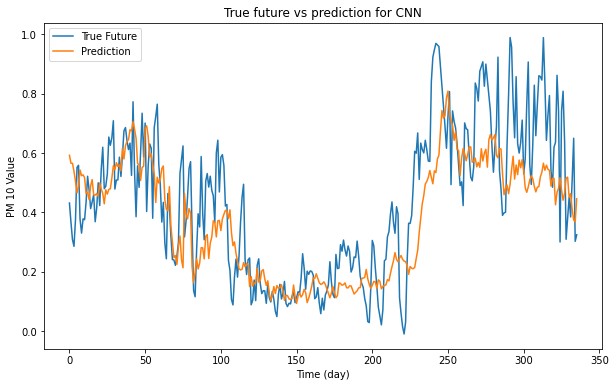

In [ ]:
def plot_future(Y_valid):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(cnn_valid_pred)

    plt.plot(np.arange(range_future), np.array(Y_valid), label='True Future')
    plt.plot(np.arange(range_future), np.array(cnn_valid_pred),label='Prediction')

    plt.title('True future vs prediction for ' + "CNN")
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    plt.savefig('D:\RESEARCH\RESEARCH PROJECT INCOMPLETE\pm10\images\predic_cnn.jpg', format='jpg', dpi=1000)

plot_future(Y_valid)

## LSTM true future vs prediction

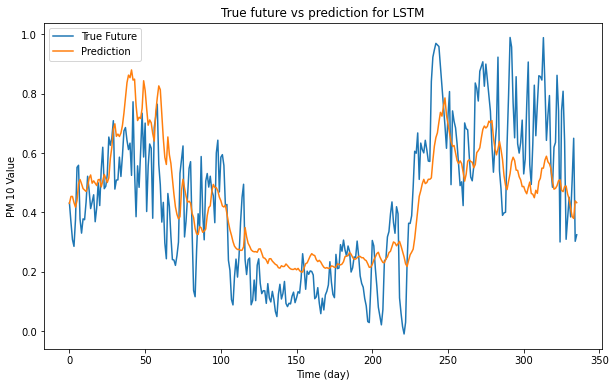

In [ ]:
def plot_future(Y_valid):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(lstm_valid_pred)

    plt.plot(np.arange(range_future), np.array(Y_valid), label='True Future')
    plt.plot(np.arange(range_future), np.array(lstm_valid_pred),label='Prediction')

    plt.title('True future vs prediction for ' + "LSTM")
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_future(Y_valid)

## Bi-LSTM true future vs prediction

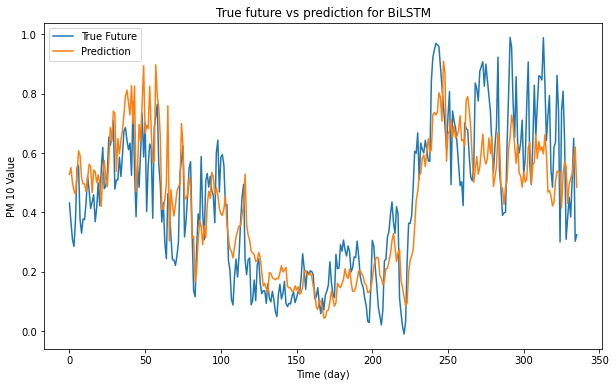

In [ ]:
def plot_future(Y_valid):
    
    plt.figure(figsize=(10, 6))
  
    range_future = len(bilstm_valid_pred)

    plt.plot(np.arange(range_future), np.array(Y_valid), label='True Future')
    plt.plot(np.arange(range_future), np.array(bilstm_valid_pred),label='Prediction')

    plt.title('True future vs prediction for ' + "BiLSTM")
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_future(Y_valid)

## GRU true future vs prediction

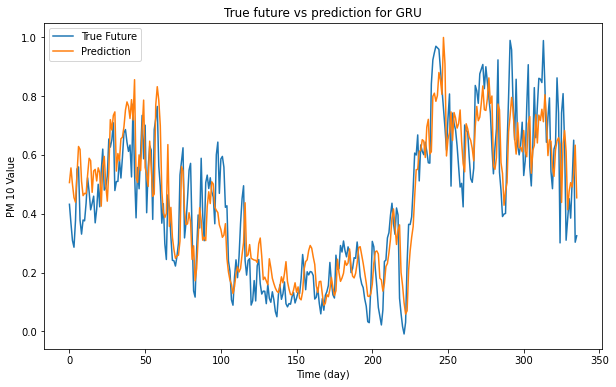

In [ ]:
def plot_future(Y_valid):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(gru_valid_pred)

    plt.plot(np.arange(range_future), np.array(Y_valid), label='True Future')
    plt.plot(np.arange(range_future), np.array(gru_valid_pred),label='Prediction')

    plt.title('True future vs prediction for ' + "GRU")
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_future(Y_valid)

## CNN-LSTM true future vs prediction

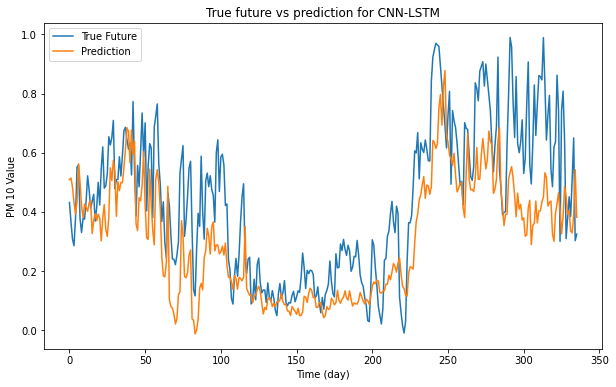

In [ ]:
def plot_future(Y_valid):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(cnn_lstm_valid_pred)

    plt.plot(np.arange(range_future), np.array(Y_valid), label='True Future')
    plt.plot(np.arange(range_future), np.array(cnn_lstm_valid_pred),label='Prediction')

    plt.title('True future vs prediction for ' + "CNN-LSTM")
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_future(Y_valid)

## CNN-BiLSTM true future vs prediction

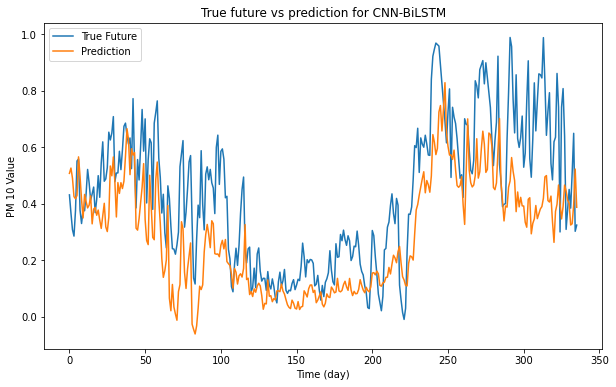

In [ ]:
def plot_future(Y_valid):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(cnn_bilstm_valid_pred)

    plt.plot(np.arange(range_future), np.array(Y_valid), label='True Future')
    plt.plot(np.arange(range_future), np.array(cnn_bilstm_valid_pred),label='Prediction')

    plt.title('True future vs prediction for ' + "CNN-BiLSTM")
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_future(Y_valid)

## CNN-GRU true future vs prediction

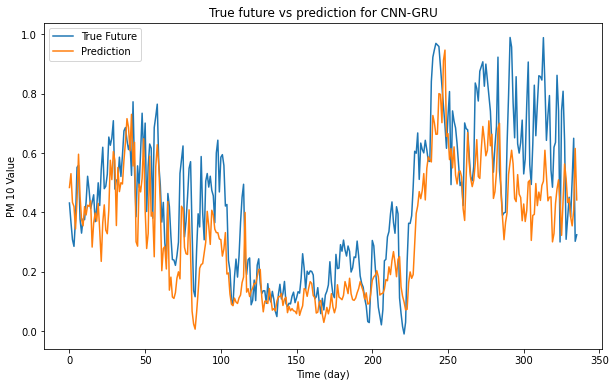

In [ ]:
def plot_future(Y_valid):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(cnn_gru_valid_pred)

    plt.plot(np.arange(range_future), np.array(Y_valid), label='True Future')
    plt.plot(np.arange(range_future), np.array(cnn_gru_valid_pred),label='Prediction')

    plt.title('True future vs prediction for ' + "CNN-GRU")
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_future(Y_valid)

#**FORECASTING**

In [ ]:
# Import climate data projection
newinput = pd.read_csv('drive/MyDrive/Colab Notebooks/check.csv', parse_dates=['date'], index_col = 'date')

# Order of the variable are important
X_new = newinput.loc['2020-01-01':'2020-11-01',:] 
X_new

,PM2dot5,NO,NO2,NOx,NH3,SO2,CO,Ozone,Wind speed
date,,,,,,,,,
2020-01-01,463.70,138.69,187.54,221.16,84.05,8.03,3.01,4.45,0.38
2020-01-02,468.71,154.67,175.03,242.23,94.45,9.94,3.56,3.38,0.22
2020-01-03,442.17,132.56,182.31,254.12,97.50,9.48,2.89,4.36,0.38
2020-01-04,465.35,114.51,192.79,239.20,89.46,7.36,2.53,3.59,0.28
2020-01-05,360.12,74.52,179.69,156.32,79.28,NaN,1.74,2.82,0.35
...,...,...,...,...,...,...,...,...,...
2020-10-28,491.30,76.29,93.24,112.38,29.82,14.84,1.83,59.50,0.20
2020-10-29,564.98,88.86,108.13,161.25,37.01,9.73,2.19,28.58,0.14
2020-10-30,512.80,54.78,78.04,86.17,29.58,4.14,1.63,2.02,0.27


In [ ]:
# Plot histoy and future data
def plot_history_future(Y_train, model):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(Y_train)
    range_future = list(range(range_history, range_history + len(model)))

    plt.plot(np.arange(range_history), np.array(Y_train), label='History')
    plt.plot(range_future, np.array(model),label='Prediction')

    plt.title('History and prediction for the best performing model')
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/3.jpg', format='jpg', dpi=1000)

In [ ]:
def forecast(X_input, time_steps, model_name):
    X = input_scaler.transform(X_input)
    X = X_input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)
    prediction_actual = model_name.predict(X_transformed)
    return prediction_actual

# CNN Forecast

9/9 [==============================] - 0s 2ms/step


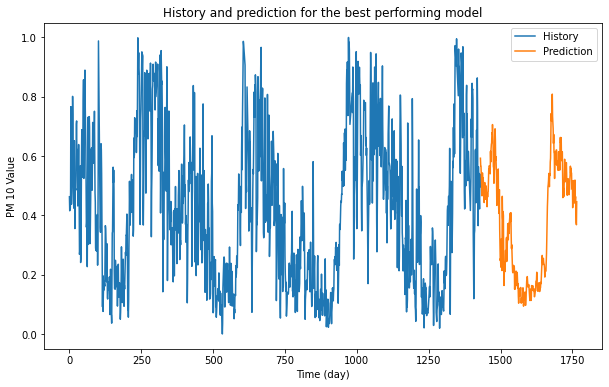

In [ ]:
prediction_actual = forecast(X_new, TIME_STEPS, model_cnn)
plot_history_future(Y_train, cnn_valid_pred)

# LSTM Forecast

9/9 [==============================] - 0s 6ms/step


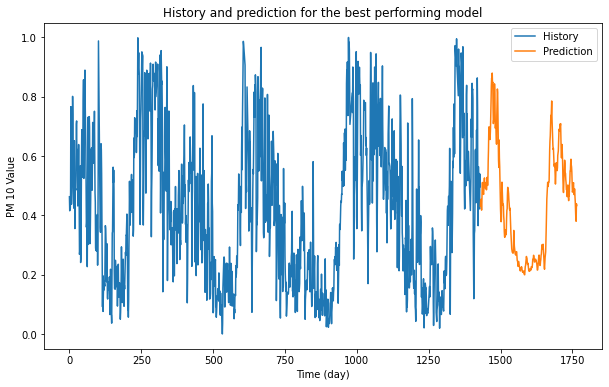

In [ ]:
prediction_actual = forecast(X_new, TIME_STEPS, model_lstm)
plot_history_future(Y_train, lstm_valid_pred)

# BiLSTM Forecast

9/9 [==============================] - 0s 8ms/step


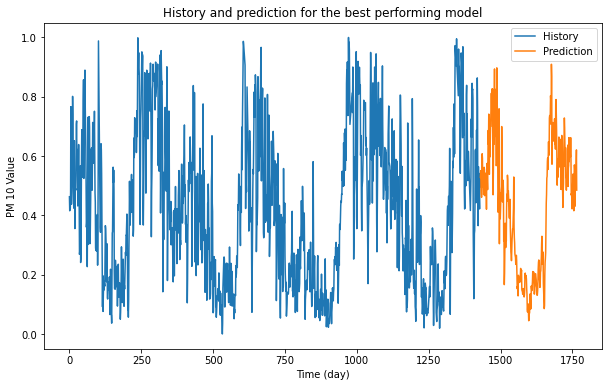

In [ ]:
prediction_actual = forecast(X_new, TIME_STEPS, model_bilstm)
plot_history_future(Y_train, bilstm_valid_pred)

# GRU Forecast

9/9 [==============================] - 0s 4ms/step


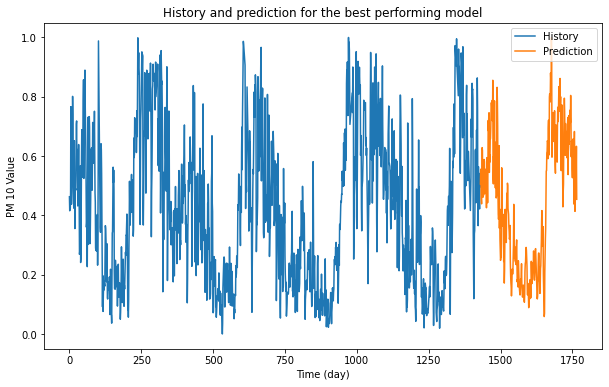

In [ ]:
prediction_actual = forecast(X_new, TIME_STEPS, model_gru)
plot_history_future(Y_train, gru_valid_pred)

# Hybrid Forecast